# Short-term Plasticity and Synchrony

Download the Jupyter notebook : [STP.ipynb](https://raw.githubusercontent.com/ANNarchy/ANNarchy.github.io/master/docs/example/STP.ipynb)

Implementation of the recurrent network proposed in:

> Tsodyks, Uziel and Markram (2000). Synchrony Generation in Recurrent Networks with Frequency-Dependent Synapses, The Journal of Neuroscience, 20(50).

This example in `examples/tsodyks_markram` shows how to define short-term plasticity (STP). 

In [1]:
from ANNarchy import *
clear()

dt=0.25
setup(dt=dt)

ANNarchy 4.7 (4.7.2) on darwin (posix).


This network uses simple leaky integrate-and-fire (LIF) neurons:

In [2]:
LIF = Neuron(
    parameters = """
    tau = 30.0 : population
    I = 15.0
    tau_I = 3.0 : population
    """,
    equations = """
    tau * dv/dt = -v + g_exc - g_inh + I : init=13.5
    tau_I * dg_exc/dt = -g_exc
    tau_I * dg_inh/dt = -g_inh
    """,
    spike = "v > 15.0",
    reset = "v = 13.5",
    refractory = 3.0
)

P = Population(geometry=500, neuron=LIF)
P.I = np.sort(Uniform(14.625, 15.375).get_values(500))
P.v = Uniform(0.0, 15.0)
Exc = P[:400]
Inh = P[400:]

Short-term plasticity can be defined by dynamical changes of synaptic efficiency, based on pre- or post-synaptic activity.

We define a STP synapse, whose post-pynaptic potential (psp, define by `g_target`) depends not only on the weight `w` and the emission of pre-synaptic spike, but also on intra-synaptic variables `x` and `u`:

In [3]:
STP = Synapse(
    parameters = """
    w=0.0
    tau_rec = 1.0
    tau_facil = 1.0
    U = 0.1
    """,
    equations = """
    dx/dt = (1 - x)/tau_rec : init = 1.0, event-driven
    du/dt = (U - u)/tau_facil : init = 0.1, event-driven   
    """,
    pre_spike="""
    g_target += w * u * x
    x *= (1 - u)
    u += U * (1 - u)
    """
)

Creating the projection between the excitatory and inhibitory is straightforward when the right parameters are chosen:

In [4]:
# Parameters for the synapses
Aee = 1.8
Aei = 5.4
Aie = 7.2
Aii = 7.2

Uee = 0.5
Uei = 0.5
Uie = 0.04
Uii = 0.04

tau_rec_ee = 800.0
tau_rec_ei = 800.0
tau_rec_ie = 100.0
tau_rec_ii = 100.0

tau_facil_ie = 1000.0
tau_facil_ii = 1000.0

# Create projections
proj_ee = Projection(pre=Exc, post=Exc, target='exc', synapse=STP)
proj_ee.connect_fixed_probability(probability=0.1, weights=Normal(Aee, (Aee/2.0), min=0.2*Aee, max=2.0*Aee)) 
proj_ee.U = Normal(Uee, (Uee/2.0), min=0.1, max=0.9)
proj_ee.tau_rec = Normal(tau_rec_ee, (tau_rec_ee/2.0), min=5.0)
proj_ee.tau_facil = dt # Cannot be 0!

proj_ei = Projection(pre=Inh, post=Exc, target='inh', synapse=STP)
proj_ei.connect_fixed_probability(probability=0.1, weights=Normal(Aei, (Aei/2.0), min=0.2*Aei, max=2.0*Aei))
proj_ei.U = Normal(Uei, (Uei/2.0), min=0.1, max=0.9)
proj_ei.tau_rec = Normal(tau_rec_ei, (tau_rec_ei/2.0), min=5.0)
proj_ei.tau_facil = dt # Cannot be 0!

proj_ie = Projection(pre=Exc, post=Inh, target='exc', synapse=STP)
proj_ie.connect_fixed_probability(probability=0.1, weights=Normal(Aie, (Aie/2.0), min=0.2*Aie, max=2.0*Aie))
proj_ie.U = Normal(Uie, (Uie/2.0), min=0.001, max=0.07)
proj_ie.tau_rec = Normal(tau_rec_ie, (tau_rec_ie/2.0), min=5.0)
proj_ie.tau_facil = Normal(tau_facil_ie, (tau_facil_ie/2.0), min=5.0)

proj_ii = Projection(pre=Inh, post=Inh, target='inh', synapse=STP)
proj_ii.connect_fixed_probability(probability=0.1, weights=Normal(Aii, (Aii/2.0), min=0.2*Aii, max=2.0*Aii))
proj_ii.U = Normal(Uii, (Uii/2.0), min=0.001, max=0.07)
proj_ii.tau_rec = Normal(tau_rec_ii, (tau_rec_ii/2.0), min=5.0)
proj_ii.tau_facil = Normal(tau_facil_ii, (tau_facil_ii/2.0), min=5.0)

We compile and simulate for 10 seconds:

In [5]:
compile()

# Record
Me = Monitor(Exc, 'spike')
Mi = Monitor(Inh, 'spike')

# Simulate
duration = 10000.0
simulate(duration, measure_time=True)

Compiling ...  OK 
Simulating 10.0 seconds of the network took 0.09651398658752441 seconds. 


We retrieve the recordings and plot them:

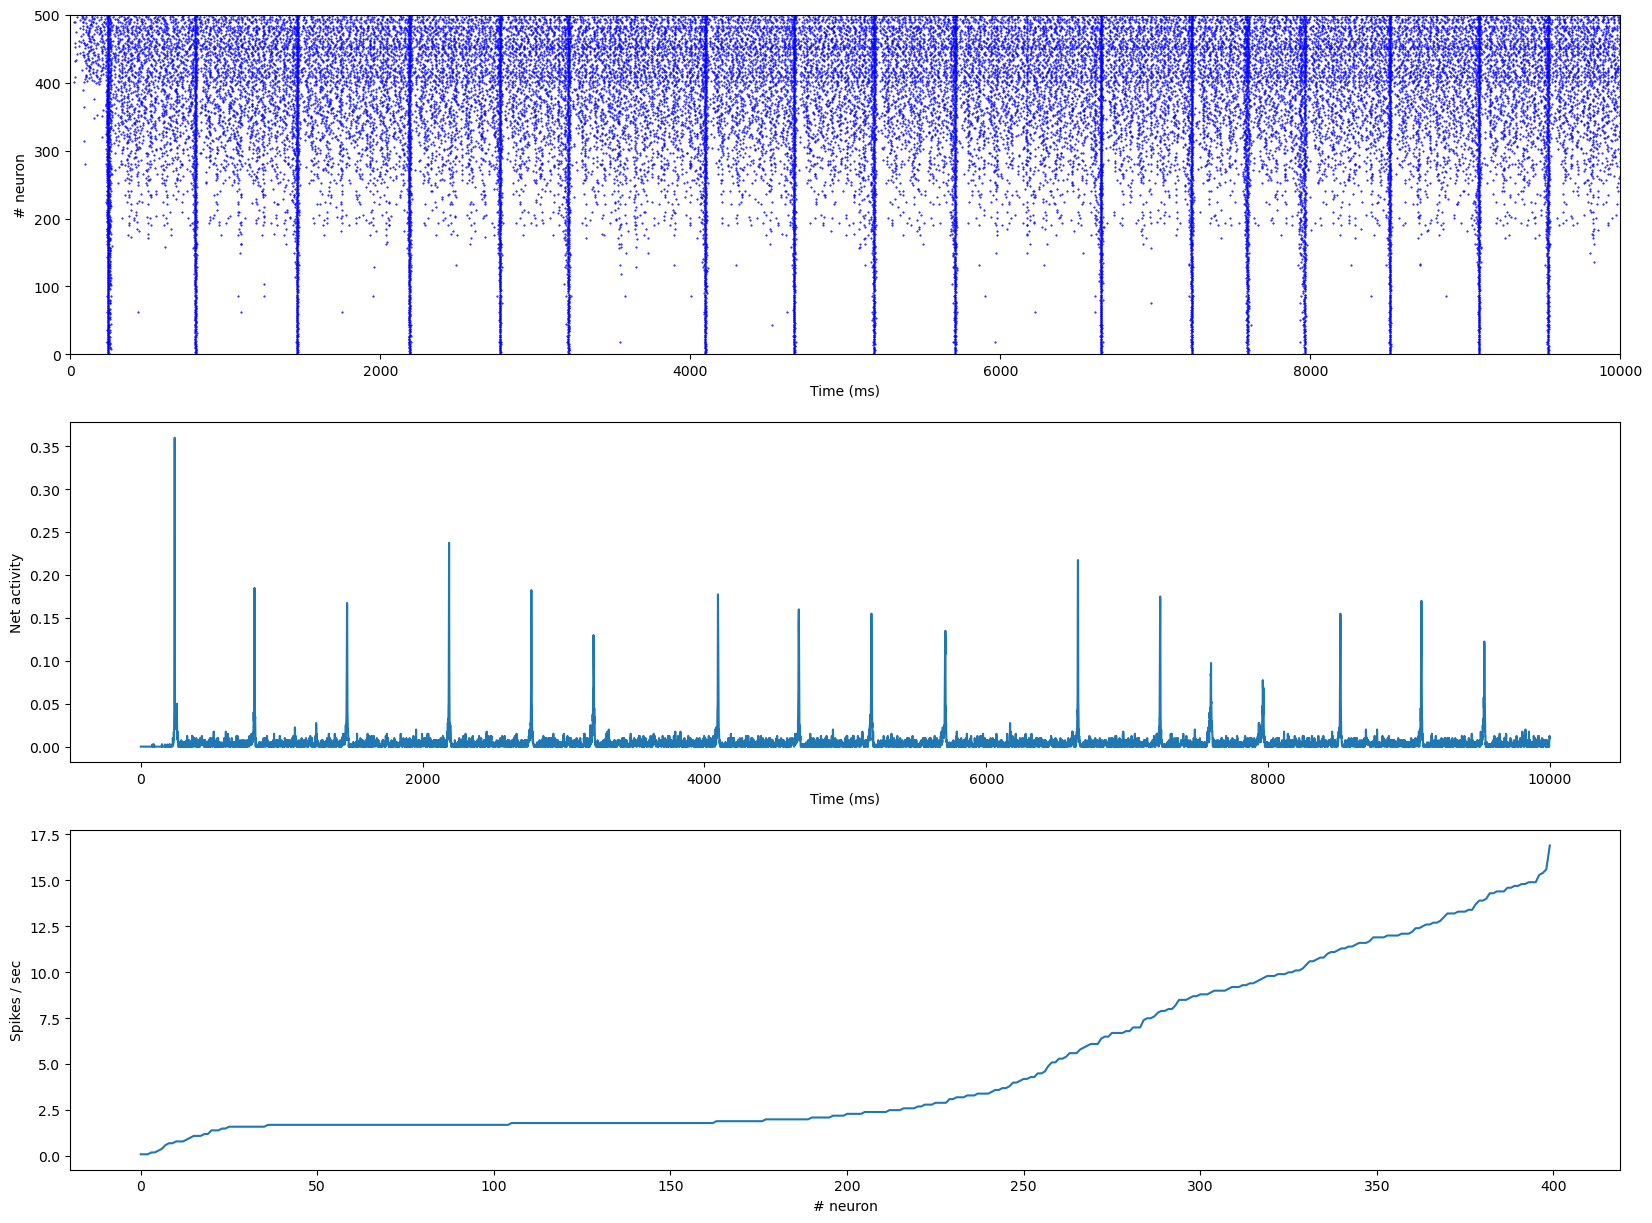

In [6]:
# Retrieve recordings
data_exc = Me.get()
data_inh = Mi.get()
te, ne = Me.raster_plot(data_exc['spike'])
ti, ni = Mi.raster_plot(data_inh['spike'])

# Histogram of the exc population
h = Me.histogram(data_exc['spike'], bins=1.0)

# Mean firing rate of each excitatory neuron
rates = []
for neur in data_exc['spike'].keys():
    rates.append(len(data_exc['spike'][neur])/duration*1000.0)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
plt.plot(te, ne, 'b.', markersize=1.0)
plt.plot(ti, ni, 'b.', markersize=1.0)
plt.xlim((0, duration)); plt.ylim((0,500))
plt.xlabel('Time (ms)')
plt.ylabel('# neuron')

plt.subplot(3,1,2)
plt.plot(h/400.)
plt.xlabel('Time (ms)')
plt.ylabel('Net activity')

plt.subplot(3,1,3)
plt.plot(sorted(rates))
plt.ylabel('Spikes / sec')
plt.xlabel('# neuron')
plt.show()